# Salary Predictions Based on Job Descriptions

### ---- 1 Define the problem ----

### Based on the given training dataset with job descriptions and associated salaries, a model needs to be prepared to predict the salary of job descriptions in the test set.

In [1]:
#import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


#my info here
__author__ = "Manik Aggarwal"
__email__ = "aggmanik@vt.edu"

### ---- 2 Load the data ----

In [90]:
# function to load the data into a Pandas dataframe 

def read_file(filename):
    dataframe = pd.read_csv(filename)
    print("The shape of dataframe:", dataframe.shape)
    return dataframe

train_features = read_file('train_features.csv')
train_salaries = read_file('train_salaries.csv')
test_features = read_file('test_features.csv')

The shape of dataframe: (1000000, 8)
The shape of dataframe: (1000000, 2)
The shape of dataframe: (1000000, 8)


### ---- 3 Examine the data ----

In [3]:
train_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [4]:
train_salaries.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [5]:
# function to merge dataframes based on column

def joining_tables(df1,df2, columns):
    merged_df = pd.merge(df1,df2, on = [columns])
    return merged_df

train_df = joining_tables(train_features,train_salaries,'jobId')
train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


### ---- 4 Clean the data ----

### Examine duplicate data: No duplicate values exist

In [6]:
train_df.duplicated().sum()

0

### Examine missing values: None missing values in any column

In [7]:
train_df.isnull().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

### Examine the training data

In [8]:
train_df.describe()

,yearsExperience,milesFromMetropolis,salary
count,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,116.061818
std,7.212391,28.877733,38.717936
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


### Data with salary zero needs to be cross verified

In [9]:
train_df[train_df.salary==0].head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [10]:
train_df[train_df.salary==0].shape

(5, 9)

### Drop rows with salary = 0

In [11]:
train_df = train_df[train_df.salary > 0]
train_df.shape

(999995, 9)

### Examine categorical features

In [12]:
train_df.describe(include = ['O'])

,jobId,companyId,jobType,degree,major,industry
count,999995,999995,999995,999995,999995,999995
unique,999995,63,8,5,9,7
top,JOB1362684739274,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236975,532353,143205


### a) Job Id is unique and needs to be dropped
### b) Most of the people do not have a major

In [13]:
train_df[train_df.major == 'NONE'].head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24,178
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54,31
10,JOB1362684407697,COMP56,JANITOR,HIGH_SCHOOL,NONE,HEALTH,24,30,102
12,JOB1362684407699,COMP4,JUNIOR,NONE,NONE,OIL,8,29,79


### ---- 4 Explore the data (EDA) ----

### Examine Target Variable distribution

Slight Right skewedness observed but data is more or less normally distributed. There are outliers which need to be examined further.

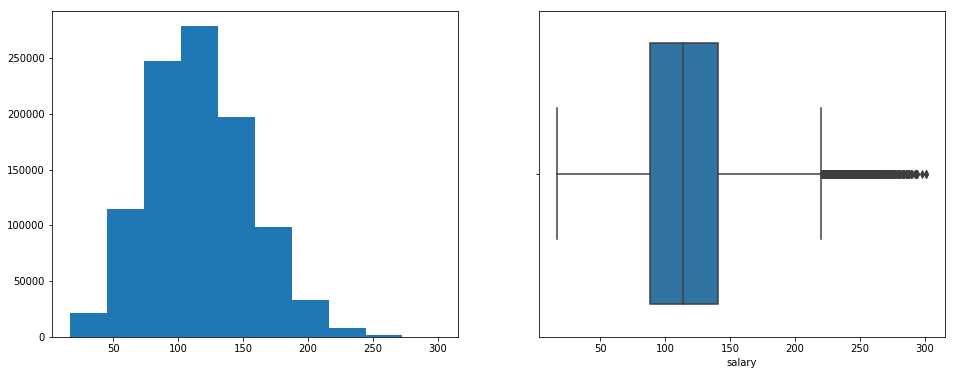

In [14]:
def plot_target(df,target_col):
    plt.figure(figsize= (16,6))
    
    plt.subplot(1,2,1)
    plt.hist(df[target_col])
    
    plt.subplot(1,2,2)
    sns.boxplot(df[target_col])

plot_target(train_df,'salary')

### Examine potential outliers

In [15]:
### function to define outliers in a continuous variable

def outliers(df, col):
    amt_stats = df[col].describe()
    IQR = amt_stats['75%'] - amt_stats['25%']
    max , min = amt_stats['75%'] + 1.5 * IQR , amt_stats['25%'] - 1.5 * IQR
    print("Lower limit:", min)
    print("Upper limit:", max)
    return

outliers(train_df,'salary')

Lower limit: 8.5
Upper limit: 220.5


### Analyse salaries beyond upper limit

In [16]:
train_df[train_df.salary > 220.5].head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
266,JOB1362684407953,COMP30,CEO,MASTERS,BIOLOGY,OIL,23,60,223
362,JOB1362684408049,COMP38,CTO,MASTERS,NONE,HEALTH,24,3,223
560,JOB1362684408247,COMP53,CEO,MASTERS,BIOLOGY,WEB,22,7,248
670,JOB1362684408357,COMP26,CEO,MASTERS,MATH,AUTO,23,9,240
719,JOB1362684408406,COMP54,VICE_PRESIDENT,DOCTORAL,BIOLOGY,OIL,21,14,225
966,JOB1362684408653,COMP32,CEO,DOCTORAL,ENGINEERING,FINANCE,23,11,247
986,JOB1362684408673,COMP37,CFO,HIGH_SCHOOL,NONE,FINANCE,24,20,229
1211,JOB1362684408898,COMP24,CTO,DOCTORAL,BUSINESS,FINANCE,5,46,232
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
1413,JOB1362684409100,COMP56,VICE_PRESIDENT,MASTERS,MATH,WEB,24,15,241


### Most high salary employees are Executive team members such as CEO, CFO, CTO except for JUNIOR job type which needs to further explored

In [17]:
train_df[(train_df.salary > 220.5) & (train_df.jobType == 'JUNIOR')].head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
189582,JOB1362684597269,COMP32,JUNIOR,DOCTORAL,BUSINESS,OIL,24,11,221
214606,JOB1362684622293,COMP47,JUNIOR,MASTERS,BUSINESS,FINANCE,22,4,222
303778,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
427593,JOB1362684835280,COMP54,JUNIOR,DOCTORAL,ENGINEERING,FINANCE,23,3,221


In [18]:
train_df[(train_df.salary > 220.5) & (train_df.jobType == 'JUNIOR')].degree.value_counts()

DOCTORAL     14
MASTERS       5
BACHELORS     1
Name: degree, dtype: int64

In [19]:
train_df[(train_df.salary > 220.5) & (train_df.jobType == 'JUNIOR')].industry.value_counts()

OIL        11
FINANCE     8
WEB         1
Name: industry, dtype: int64

### Key Observation: 

### Junior roles are paid very high in Oil and Finance Industry which seems to make sense. Highest paid junior roles generally hold a Doctoral or Masters degree which is logical.

### So the outliers above upper limit need not be dropped from the dataset.

### Examine feature companyID: Not much information available hence can be dropped

In [20]:
train_df.companyId.value_counts(1)

COMP39    0.016193
COMP35    0.016114
COMP59    0.016066
COMP30    0.016041
COMP3     0.016028
COMP40    0.016007
COMP51    0.016005
COMP44    0.016004
COMP9     0.015988
COMP56    0.015979
COMP54    0.015977
COMP46    0.015967
COMP58    0.015961
COMP19    0.015958
COMP32    0.015958
COMP18    0.015957
COMP13    0.015956
COMP43    0.015955
COMP21    0.015949
COMP42    0.015943
COMP62    0.015943
COMP25    0.015931
COMP48    0.015930
COMP23    0.015918
COMP4     0.015918
COMP20    0.015910
COMP10    0.015909
COMP14    0.015908
COMP22    0.015907
COMP37    0.015905
            ...   
COMP41    0.015859
COMP45    0.015850
COMP6     0.015837
COMP24    0.015831
COMP61    0.015822
COMP1     0.015820
COMP38    0.015819
COMP34    0.015809
COMP33    0.015801
COMP60    0.015799
COMP5     0.015798
COMP47    0.015796
COMP28    0.015794
COMP50    0.015791
COMP12    0.015783
COMP16    0.015783
COMP49    0.015779
COMP53    0.015776
COMP27    0.015773
COMP7     0.015767
COMP55    0.015767
COMP31    0.

### Examine each feature separately and against target variable

In [21]:
### function for plotting each feature

def plot_features(df,column, target):
    plt.figure(figsize=(24,8))
    
    ### the left plot shows the frequency distribution for continous variable or countplot for categorical variable
    
    plt.subplot(1,2,1)
    
    if (df[column].dtype == 'int64' or df[column].dtype == 'float64'):
        plt.hist(df[column])
    else:
        sns.countplot(x =column, data = df, order = df[column].value_counts().index)
        
    plt.xticks(rotation = 90)
    plt.ylabel('Count', fontsize = 15)
    plt.xlabel(column, fontsize = 15)
    
    ### the right plot shows the scatter plot for continuous variable or box plot for categorical variable
    
    plt.subplot(1,2,2)
    
    if (df[column].dtype == 'int64' or df[column].dtype == 'float64'):
        plt.scatter(df[column] , df[target], alpha = 0.1)       
    else:
        sns.boxplot(x = column, y = target, data = df)
        
    ## plotting 
    plt.xlabel(column, fontsize =15)
    plt.ylabel(target, fontsize = 15)
    plt.xticks(rotation =90, fontsize = 15)
    plt.show()

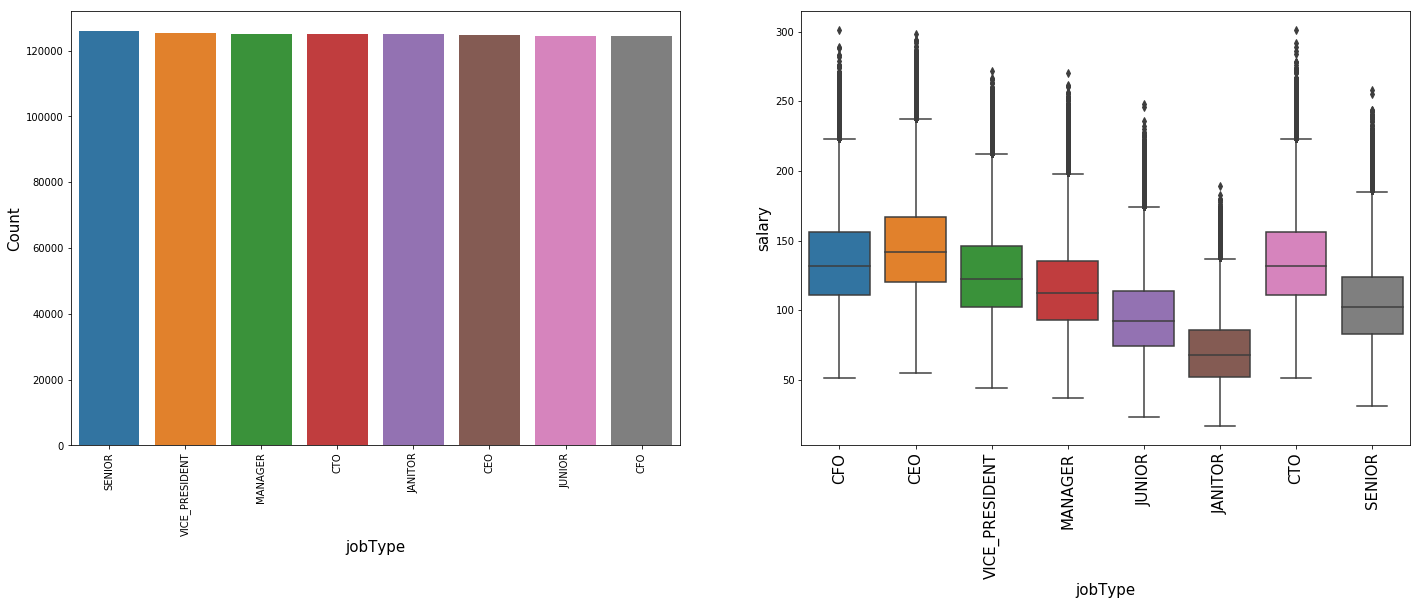

In [22]:
plot_features(train_df,'jobType','salary')

### The median salary distribution for each job type seems logical with CEO,CTO,CFO highest paid and Janitor, junior less paid 

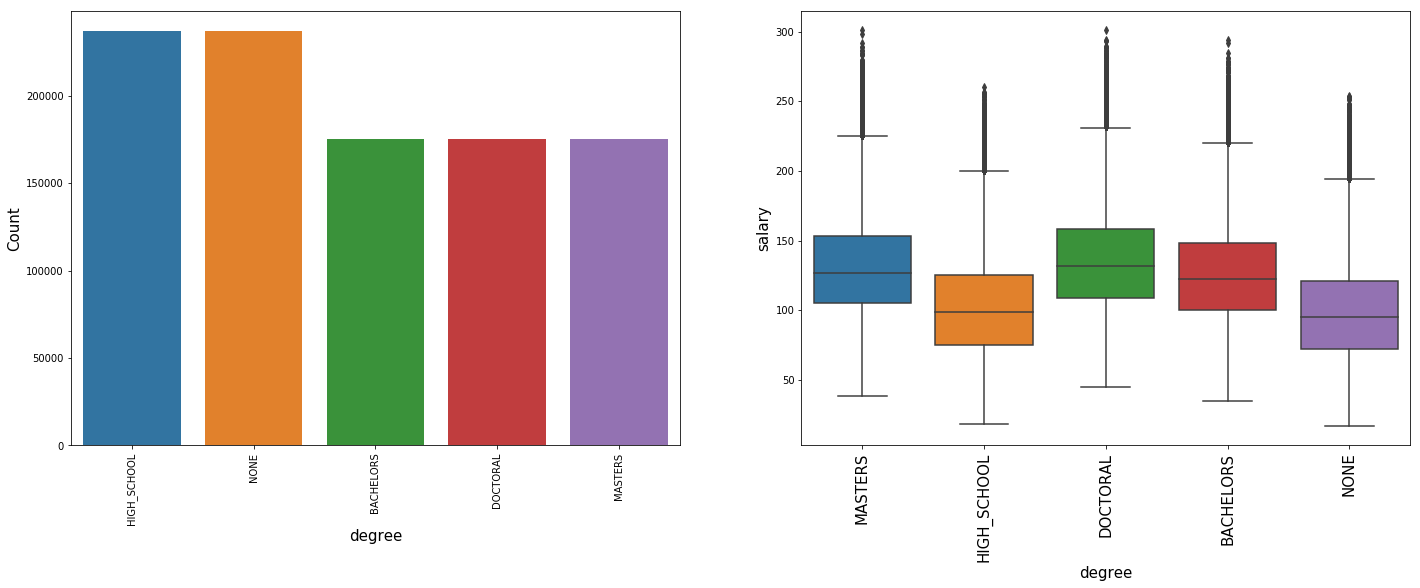

In [23]:
plot_features(train_df,'degree','salary')

### The median distribution seems all good with masters and doctoral degree being the highest paid

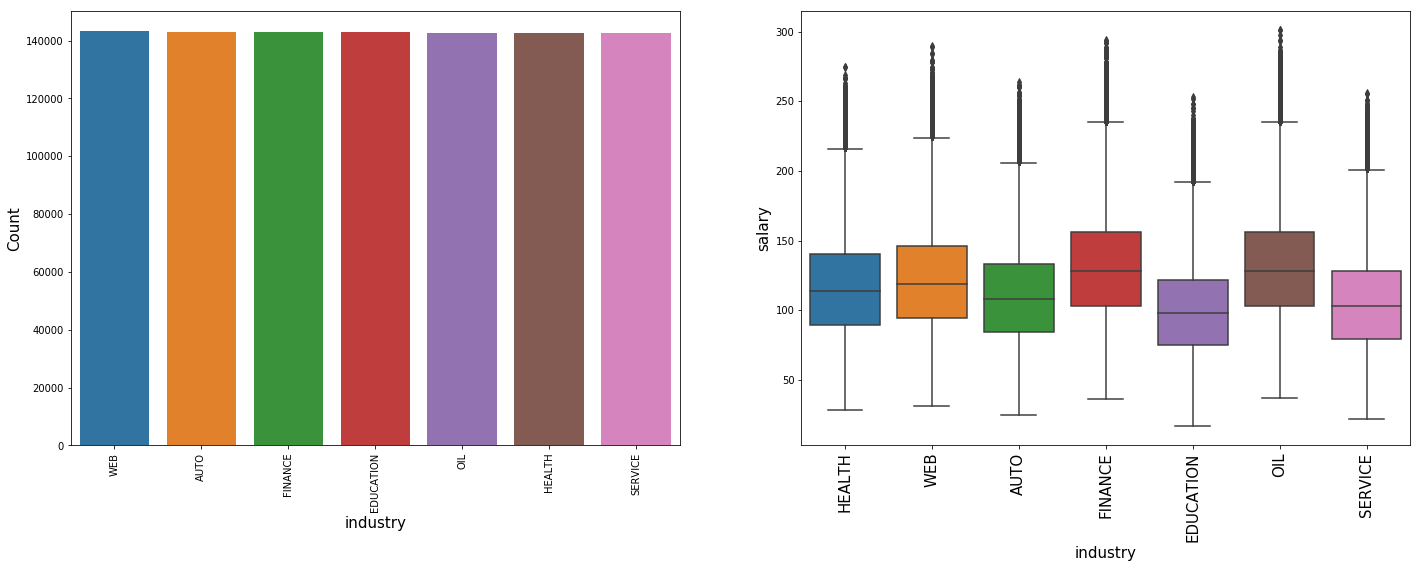

In [24]:
plot_features(train_df,'industry','salary')

### Finance and Oil industry paid more than others which are similarly paid

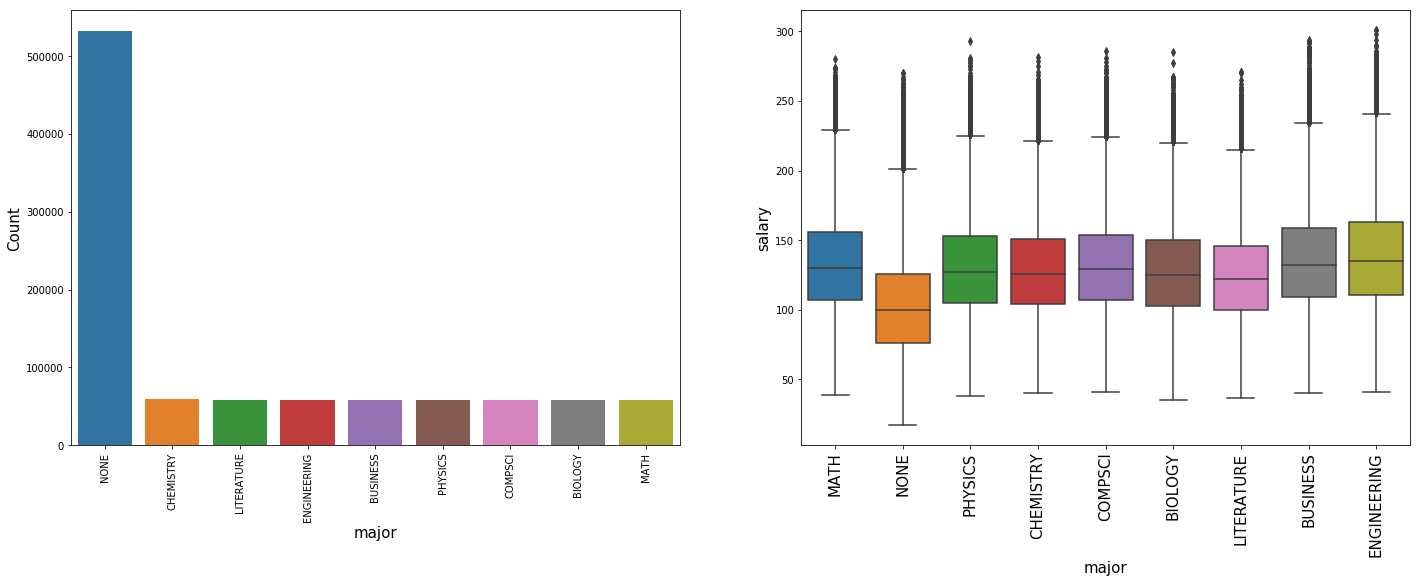

In [25]:
plot_features(train_df,'major','salary')

### All majors seems to be equally paid apart from None which makes sense

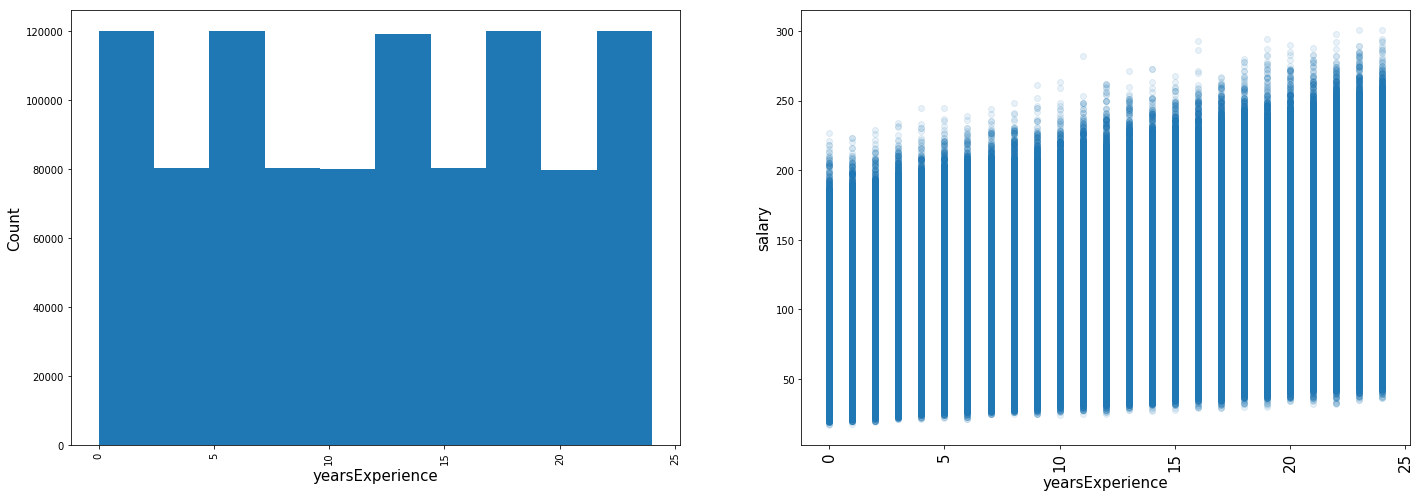

In [26]:
plot_features(train_df,'yearsExperience','salary')

### With increase in years of experience, there is slight increasing trend in the salary which is also logical 

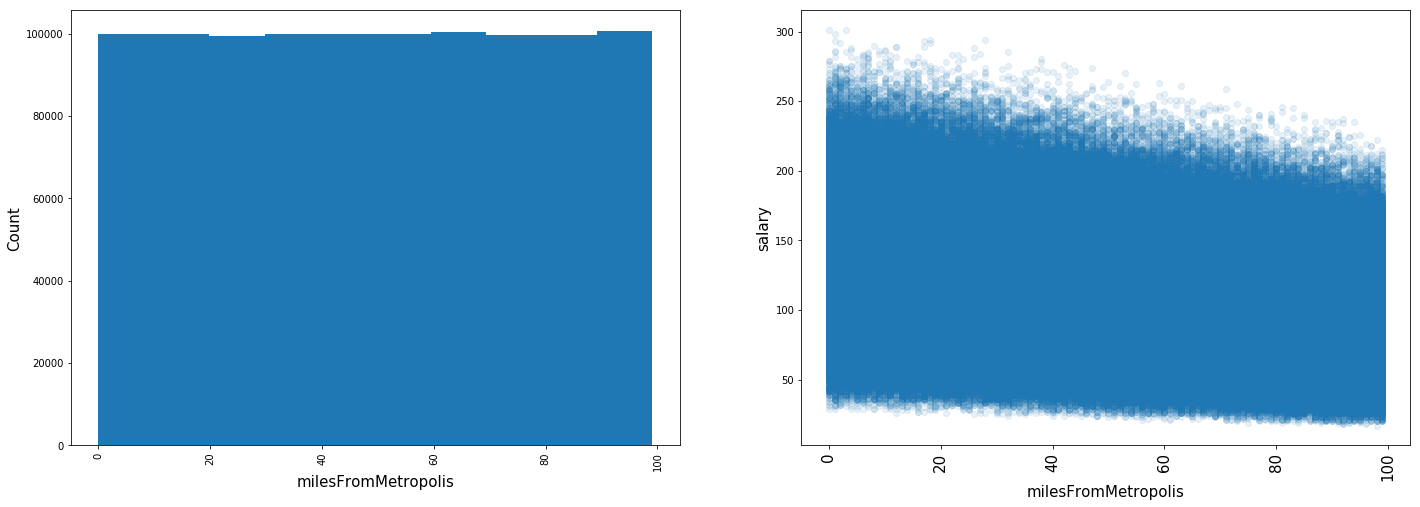

In [27]:
plot_features(train_df,'milesFromMetropolis','salary')

### There is slight decrease trend in salary as miles from metropolis increase

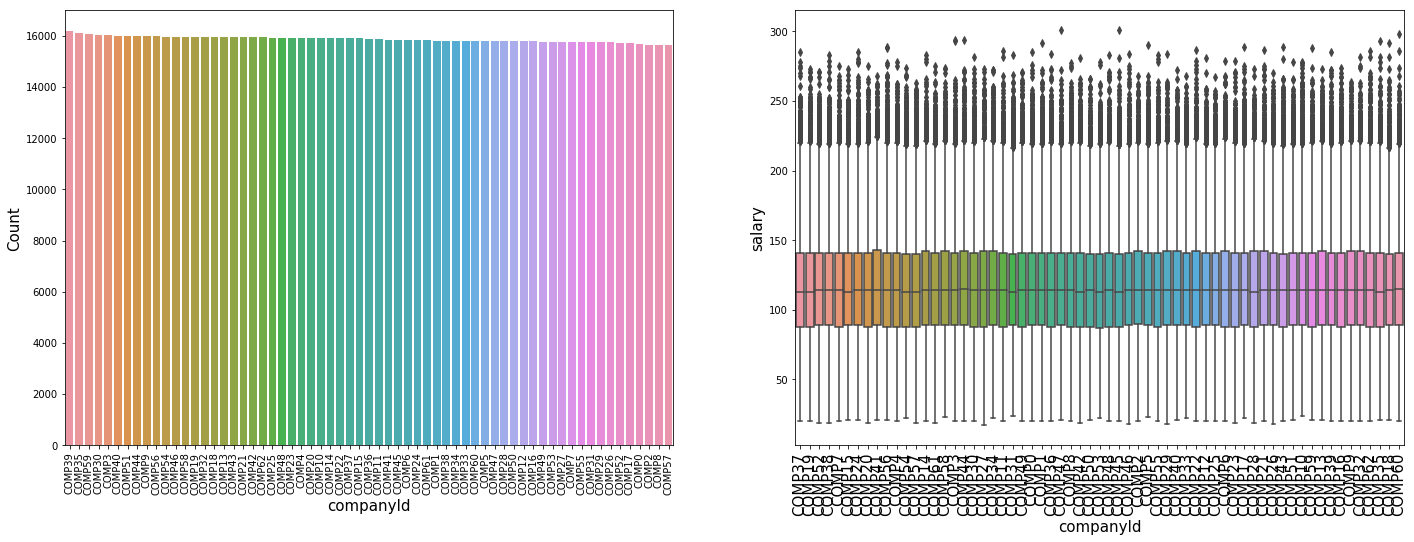

In [28]:
plot_features(train_df,'companyId','salary')

### Examine relation between years of experience, miles from metropolis and salary

Wall time: 3.86 s


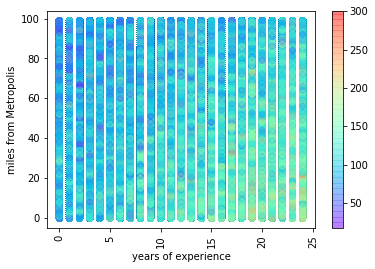

In [29]:
%%time

## Creat a scatter plot between years of experience and miles from metropolis with color of bubble depicting salary range

plt.scatter(train_df['yearsExperience'] , train_df['milesFromMetropolis'], c= train_df['salary'], cmap = 'rainbow', alpha = 0.3) 
plt.xlabel('years of experience')
plt.ylabel('miles from Metropolis')
plt.xticks(rotation = 90)
plt.colorbar()

### Above plot shows higher salaries are for employees with higher years of experience & less distance from metropolis: 2 clusters are visible hence we can use some kind of clustering technique

### Hypothesis 1: Similar years of experience in different industry can have different salaries

In [29]:
## Function for creating new categorical experience feature
## Expereince feature to be categorised into 0-2, 2-5,5-10, 10-15, 15-30 bins

def preprocess_experience(df):
    cut_points = [0, 2, 5, 10, 15, 30]
    label_names = ['0-2','2-5','5-10','10-15','15-30']
    df['years_category'] = pd.cut(df["yearsExperience"],cut_points,labels = label_names, right = False)
    return df

In [30]:
train_df = preprocess_experience(train_df)

In [31]:
train_df.years_category.value_counts()

15-30    400014
5-10     200507
10-15    199100
2-5      120271
0-2       80103
Name: years_category, dtype: int64

In [32]:
train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,years_category
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,10-15
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101,2-5
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137,10-15
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142,5-10
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163,5-10


### Evaluation of Hypothesis 1: Examine boxplot for median salary across different industries with similar years of work experience

In [33]:
## Function defined for creating box plots based on dataframe, feature and target variable passed in as arguments

def box_plot(df, feature, target):
    sns.boxplot(x = feature, y = target, data = df)
    plt.xlabel(feature, fontsize =15)
    plt.ylabel(target, fontsize = 15)
    plt.xticks(rotation =90, fontsize = 15)
    
    plt.show()

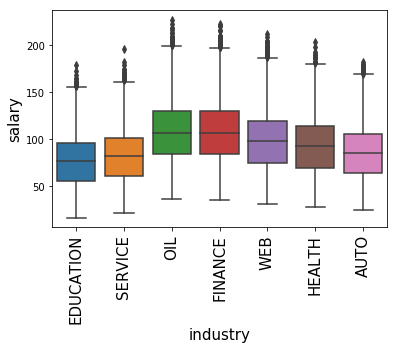

In [34]:
box_plot(train_df[train_df.years_category == '0-2'], 'industry', 'salary')

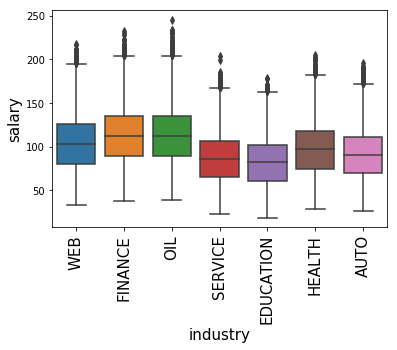

In [35]:
box_plot(train_df[train_df.years_category == '2-5'], 'industry', 'salary')

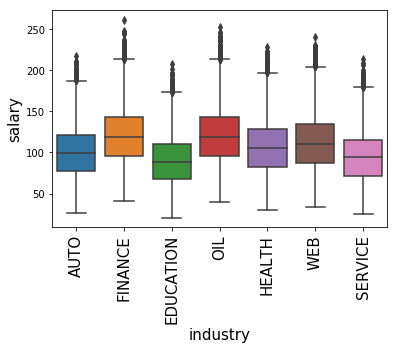

In [36]:
box_plot(train_df[train_df.years_category == '5-10'], 'industry', 'salary')

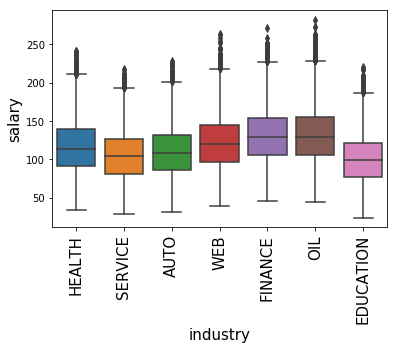

In [37]:
box_plot(train_df[train_df.years_category == '10-15'], 'industry', 'salary')

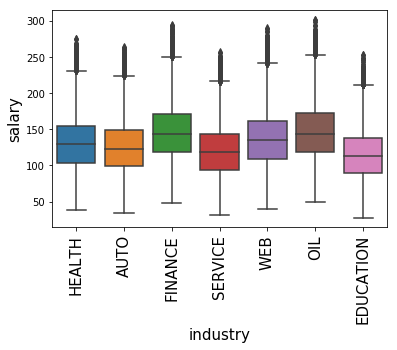

In [38]:
box_plot(train_df[train_df.years_category == '15-30'], 'industry', 'salary')

### Hypothesis 1 result: Our hypothesis was true since as per the above 5 plots for any years of experience category, Oil and finance and Web have higher salaries and education the lowest

### Hypothesis 2: Similar roles in companies could be paid differently across different industries

In [39]:
## Create a list of distinct job types in the dataset

job_types = list(train_df.jobType.value_counts().index)

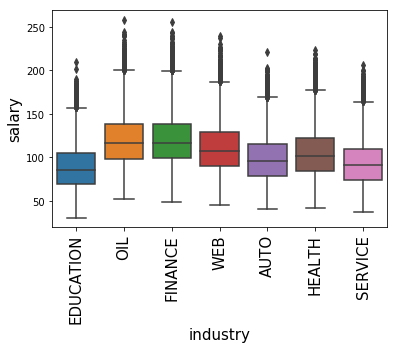

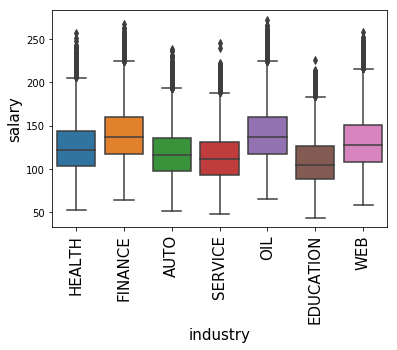

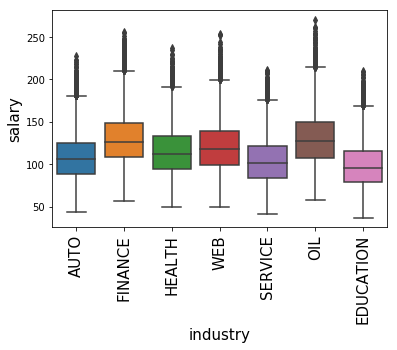

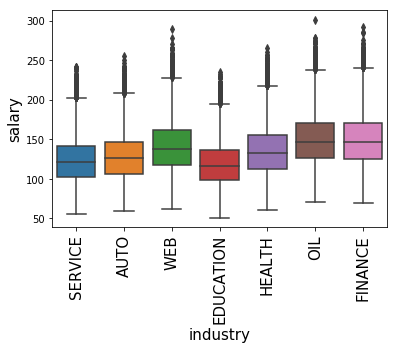

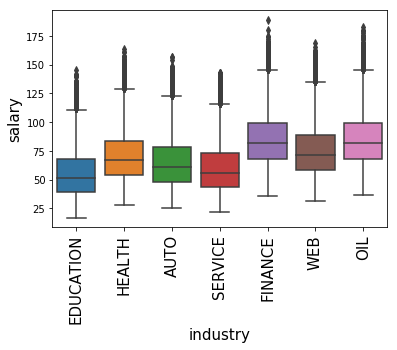

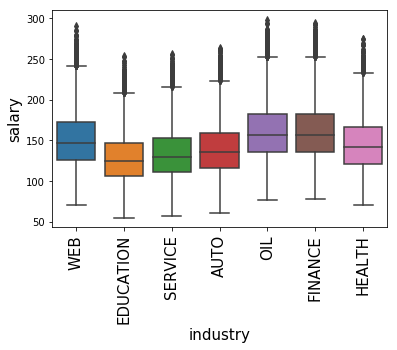

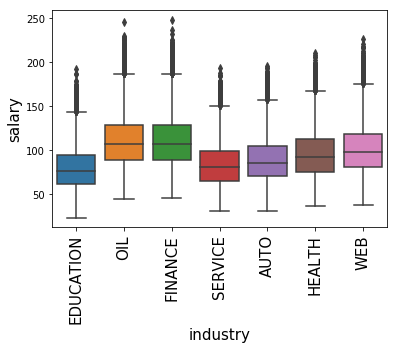

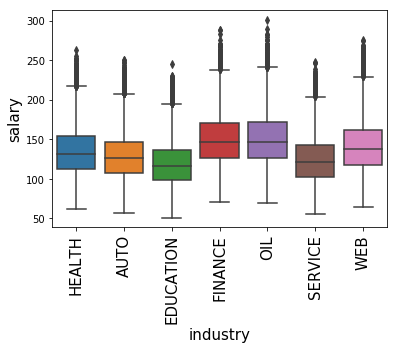

In [40]:
### Iterate through each value in job type list and create box plots to examine any significant difference in median salary

for value in job_types:
    box_plot(train_df[train_df.jobType == value], 'industry','salary')

### Hypothesis 2 result: Our hypothesis was correct as we do observe for each job type, Oil and finance and Web are paid more than others while education is paid the least

### Hypothesis 3: Certain industries pay more for locations away from Metropolis

In [41]:
## Define a function that create a new feature with uniform bins of size 25 for miles from metropolis feature

def preprocess_miles(df):
    cut_points = [0, 25, 50, 75, 100]
    label_names = ['Near','Not Far','Far','Very Far']
    df['miles_category'] = pd.cut(df["milesFromMetropolis"],cut_points,labels = label_names, right = False)
    return df

In [42]:
### Create a new variable for categorising miles from metropolis in four categories of size 25.

train_df = preprocess_miles(train_df)

In [43]:
train_df.miles_category.value_counts()

Far         250383
Very Far    250171
Not Far     249838
Near        249603
Name: miles_category, dtype: int64

### Evaluation of Hypothesis 3: Examine Plot for salary values across different industry for different miles category

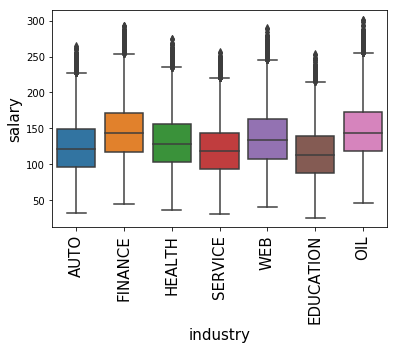

In [44]:
box_plot(train_df[train_df.miles_category == 'Near'],'industry','salary')

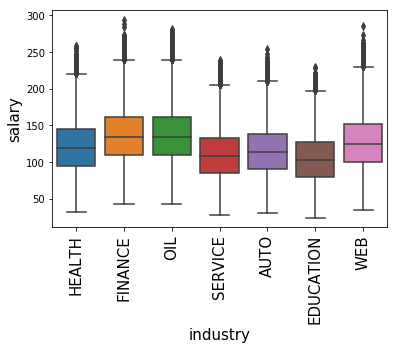

In [45]:
box_plot(train_df[train_df.miles_category == 'Not Far'],'industry','salary')

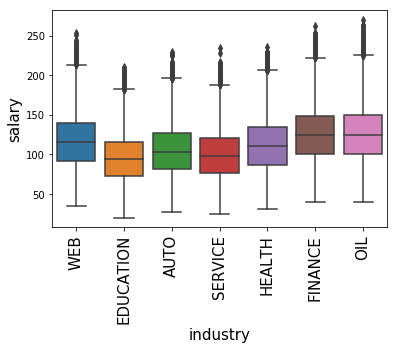

In [46]:
box_plot(train_df[train_df.miles_category == 'Far'],'industry','salary')

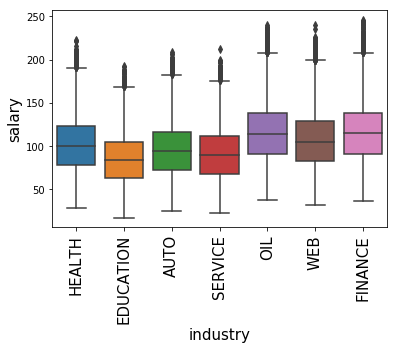

In [47]:
box_plot(train_df[train_df.miles_category == 'Very Far'],'industry','salary')

### Hypothesis 3 result: Our Hypothesis was correct since Oil, finance and Web are paid more than the rest of the industries while education the least.

### Plot correlation matrix

In [48]:
## Function to plot correlation matrix for continuous features by passing dataframe as the argument

def correlation_matrix(df):
    fig = plt.figure(figsize=(8,6))
    sns.heatmap(df.corr(),cmap = 'Blues',annot = False)
    plt.xticks(rotation=90)
    plt.show()

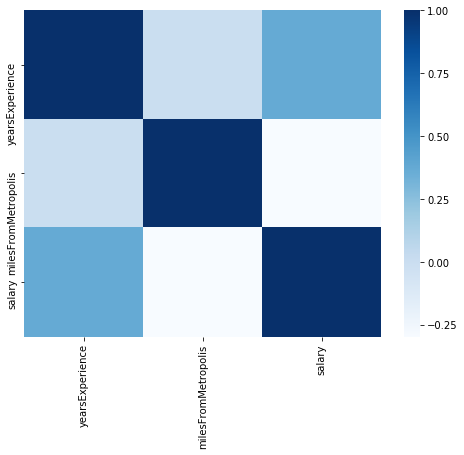

In [49]:
correlation_matrix(train_df)

### Observation: Salary is highly positively correlated with years of experience and negatively correlated with miles from metropolis. This is strengthens our initial finding from individual plot for years experience and miles feature

### ---- 5 Establish a baseline ----

### Data preprocessing and preparing for modeling

In [50]:
###  We intend to use only the initial known features for baseline model

cat_features = ['jobType','degree','major','industry']
num_features =['yearsExperience','milesFromMetropolis']

## Create numerical feautres and response variable dataframe

num_df = train_df[num_features]
y_train = train_df['salary']

In [51]:
## function to create dummy variables for categorical features for the dataframe passed in as argument

def feature_encoding(df, feature_list):
    df_new = pd.get_dummies(df, columns= feature_list, drop_first = True)
    return df_new

cat_df = feature_encoding(train_df[cat_features], cat_features)

### Concatenating numerical and categorical feature dataframe

X_train = pd.concat([cat_df, num_df], axis = 1)
X_train.shape

(999995, 27)

### Feature scaling on training data

In [52]:
## Feature scaling for the training data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

## scaling the training set

X_train_scaled = scaler.transform(X_train)

### Performance metric function: Metric chosen is mean squared error

In [53]:
### Metric for performance measure considered in mean squared error

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict

## Function to calcuate the required metric for all the models

def model_metric_scores(estimator,df_X,df_Y,cv_fold):
    
    ## checking mse
    
    estimator_predict = cross_val_predict(estimator,df_X,df_Y, cv=cv_fold)
    print("The best MSE Score for given data:",mean_squared_error(df_Y,estimator_predict))
    return (mean_squared_error(df_Y,estimator_predict))

### Fitting Linear Regression as our baseline model

In [54]:
### fit linear regression model
### Since our main goal is prediction hence multicollinearity is not much of a problem

from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr_baseline_mse = model_metric_scores(lr, X_train_scaled, y_train,10)

The best MSE Score for given data: 384.40963918084543


### ---- 6 Hypothesize solution ----

### Feature engineering:
    1) Categorize milesfromMetropolis feature
    2) Categorize YearsofExperience feature
    
Brainstorm 3 models that may improve results over the baseline model based on EDA

    1) Linear Regression with L1/L2 regularization: Since we observed some linear relationships between miles, years of experience with salary during EDA
    2) Random forest: Since most of the features are categorical including the new features hence random forest is a good for finding non linear relationships
    3) Gradient Boosting: For sequential reduction of error and capturing non linear relationships

### ---- 7 Engineer features and data preparation ----

### Categories for levels of experience and miles from metropolis already created

### Prepare the data for modeling

In [55]:
## function to drop specific list of columns in the dataframe by passing in the dataframe and column list as arguments

def drop_columns(df, col):
    df = df.drop(col, axis=1)
    return df

In [56]:
## Drop job ID and company ID column from the dataframe

train_df = drop_columns(train_df,['jobId','companyId'])

###  Create X training and y training dataframe

y_train = train_df['salary']
X_train = train_df.drop(['salary'], axis = 1)

X_train.shape

(999995, 8)

In [57]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999999
Data columns (total 8 columns):
jobType                999995 non-null object
degree                 999995 non-null object
major                  999995 non-null object
industry               999995 non-null object
yearsExperience        999995 non-null int64
milesFromMetropolis    999995 non-null int64
years_category         999995 non-null category
miles_category         999995 non-null category
dtypes: category(2), int64(2), object(4)
memory usage: 95.3+ MB


In [58]:
## function to create list of numerical and categorical features using dataframe as input argument

def features_set(df):
    numerical_var = df.select_dtypes(include = [np.number]).columns.tolist() ## creating list of numerical features
    categorical_var = df.select_dtypes(include = ['O','category']).columns.tolist()     ## creating list of categorical features
    return numerical_var, categorical_var

### Create list of numerical and categorical features using predefined function

num_var, cat_var = features_set(X_train)

### Creating dummy features for categorical features in the X_train dataframe

X_train_final = feature_encoding(X_train, cat_var)
X_train_final.shape

(999995, 34)

In [59]:
X_train_final.head()

,yearsExperience,milesFromMetropolis,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,degree_DOCTORAL,...,industry_OIL,industry_SERVICE,industry_WEB,years_category_2-5,years_category_5-10,years_category_10-15,years_category_15-30,miles_category_Not Far,miles_category_Far,miles_category_Very Far
0,10,83,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,3,73,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
2,10,38,0,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,1,0,0
3,8,17,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,8,16,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


### ---- 8 Create models ----

### Applying Linear regression with scaled all features

In [60]:
scaler = StandardScaler().fit(X_train_final)

## scaling the training set

X_train_final_scaled = scaler.transform(X_train_final)

In [61]:
lr = LinearRegression()
lr_mse = model_metric_scores(lr, X_train_final_scaled, y_train,10)

The best MSE Score for given data: 384.4141414004574


### Results of linear regression after and before feature engineering are the same

### Applying ridge regression (L2 regularization with linear regression)

In [62]:
from sklearn.linear_model import Ridge

### Define validation curve function for model parameter tuning

In [63]:
from sklearn.model_selection import validation_curve

def curve_validation(model, parameter_name,parameter_values, df_x, df_y, scoring_type, cv_fold):
    
    plt.figure(figsize=(8,6))
     
    # Plot validation curve
    train_scores, validation_scores = validation_curve(estimator = model, X= df_x, y = df_y, param_name= parameter_name, 
                                                   param_range= parameter_values,
                                                   cv = cv_fold,
                                                   scoring = scoring_type)

    train_mean = np.mean(train_scores,axis=1)
    train_std = np.std(train_scores,axis=1)
    validation_mean = np.mean(validation_scores,axis=1)
    validation_std = np.std(validation_scores,axis=1)

    plt.plot(parameter_values, train_mean, color='blue', marker='o', markersize=5, label='training mse')
    plt.plot(parameter_values, validation_mean, color='green', marker='x', markersize=5, label='validation mse') 
    
    plt.xlabel('parameter')
    plt.ylabel('Score')
    plt.legend(loc='lower right')
#     plt.ylim([0.5,1])

### Validation curve for optimizing value of alpha in Ridge regression
### There is not much change in mse score for both training and validation hence we can take alpha = 100

Wall time: 1min 25s


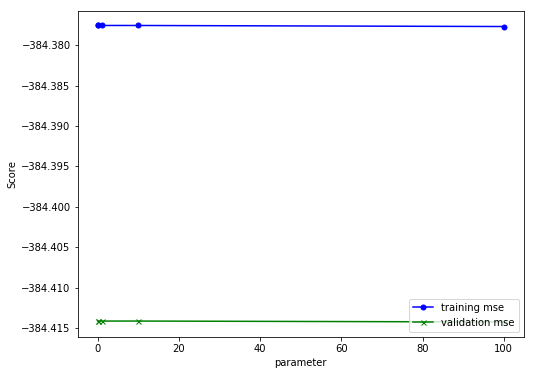

In [68]:
%%time
ridge_reg = Ridge(random_state= 6)
curve_validation(ridge_reg, 'alpha', [0.01, 0.1, 1, 10, 100], X_train_final_scaled, y_train, 'neg_mean_squared_error', 10)

### Fitting Ridge regression with alpha = 100

In [64]:
%%time 
ridge_reg = Ridge(random_state= 6, alpha = 100)
ridge_mse = model_metric_scores(ridge_reg, X_train_final_scaled, y_train, 10)

The best MSE Score for given data: 384.41425527988343
Wall time: 16.4 s


### Using Lasso regression (L1 regularization) with linear regression

In [65]:
from sklearn.linear_model import Lasso

### Plot validation curve for tuning alpha parameter

Wall time: 27min 37s


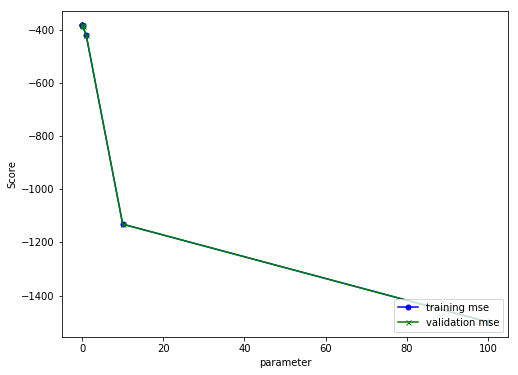

In [68]:
%%time
lasso_reg = Lasso(random_state= 7)
curve_validation(lasso_reg, 'alpha', [1e-8, 1e-4,0.01, 0.1, 1, 10, 100], X_train_final_scaled, y_train, 'neg_mean_squared_error', 10)

### Fit Lasso Regression

In [66]:
%%time
lasso_reg = Lasso(random_state= 7, alpha = 0.01)
lasso_mse = model_metric_scores(lasso_reg, X_train_final_scaled, y_train, 10)

The best MSE Score for given data: 384.41866330901314
Wall time: 1min 39s


### Both Ridge and Lasso did not give any different results from each other and linear regression
### Lets try non parametric models 

### Random Forest

Used since most of the features are categorical hence non linear relationships can be explored with this technique

In [67]:
%%time

from sklearn.ensemble import RandomForestRegressor

## fitting the random forest regressor and find important features

RF = RandomForestRegressor(random_state=27,
                            n_estimators= 40 , max_depth= 20, 
                            min_samples_split = 20, max_features = 0.55,
                            min_samples_leaf = 10, n_jobs = -1)

### Checking 10 fold cross validation mse score for random forest 
rf_mse = model_metric_scores(RF, X_train_final, y_train ,5)

The best MSE Score for given data: 369.3830390097283
Wall time: 4min 18s


### Finding feature importance

jobType_JANITOR            0.213388
yearsExperience            0.136038
milesFromMetropolis        0.113967
jobType_JUNIOR             0.093885
major_NONE                 0.083982
jobType_SENIOR             0.057130
years_category_15-30       0.045862
jobType_MANAGER            0.033521
industry_EDUCATION         0.032144
industry_OIL               0.024140
industry_FINANCE           0.023662
miles_category_Very Far    0.019165
industry_SERVICE           0.018525
degree_NONE                0.016954
jobType_VICE_PRESIDENT     0.014785
industry_WEB               0.009554
degree_DOCTORAL            0.008314
degree_HIGH_SCHOOL         0.006736
years_category_10-15       0.005691
major_ENGINEERING          0.005662
jobType_CFO                0.004759
jobType_CTO                0.004360
major_BUSINESS             0.004250
miles_category_Far         0.004054
industry_HEALTH            0.003939
miles_category_Not Far     0.003539
degree_MASTERS             0.002647
major_LITERATURE           0

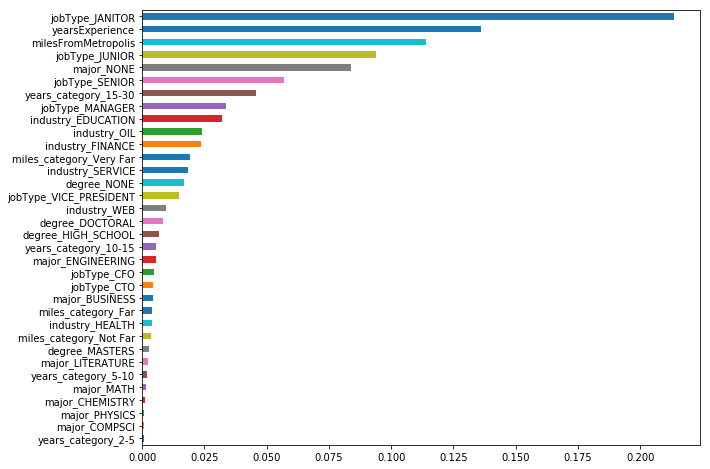

In [68]:
### feature importance
RF = RF.fit(X_train_final,y_train)
feature_importances = pd.Series(RF.feature_importances_, index = X_train_final.columns)
feature_importances.sort_values(inplace = True)
print(feature_importances.sort_values(ascending=False))
feature_importances.plot(kind ='barh',figsize=(10,8))

### job type_Janitor, miles from metropolis and years of experience are most important features.
### year_category, miles category features engineered were not much relevant

### Using Light GBM

In [69]:
import lightgbm as lgbm

In [70]:
lgbm.LGBMRegressor()

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### Examine maximum depth by plotting validation curve

### Validation curve shows the training mse becomes almost constant after max depth of 7.

Wall time: 5min 23s


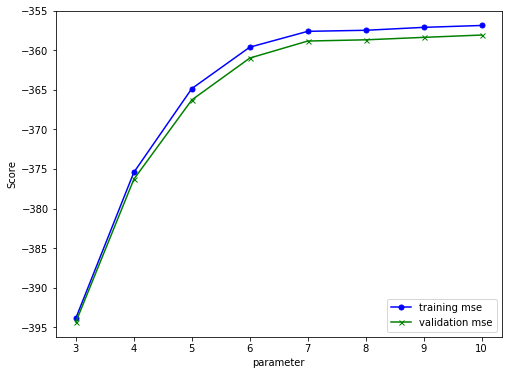

In [67]:
%%time
# Apply lightGBM regressor model to training data
lgbmRegressor = lgbm.LGBMRegressor(random_state = 3, n_jobs = -1, objective = 'regression')
curve_validation(lgbmRegressor, 'max_depth',[3,4,5,6,7,8,9,10], X_train_final, y_train,'neg_mean_squared_error', 5)

### Examine learning rate by plotting validation curve

### Validation curve shows training mse get constant at learning rate of 0.1

Wall time: 4min 33s


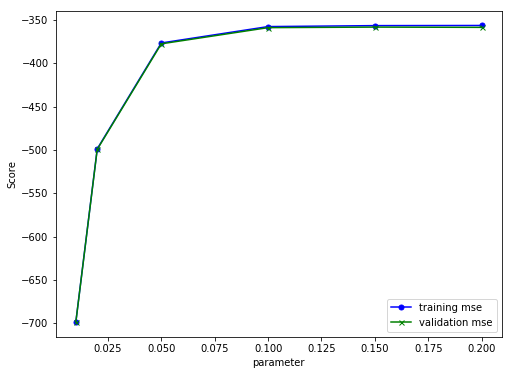

In [68]:
%%time
# Apply lightGBM regressor model to training data
lgbmRegressor = lgbm.LGBMRegressor(random_state = 3, max_depth = 7, objective ='regression', n_jobs = -1)
curve_validation(lgbmRegressor, 'learning_rate',[0.01,0.02,0.05,0.1,0.15,0.2], X_train_final, y_train,'neg_mean_squared_error', 5)

### Examine n_estimator parameter based on validation curve

### n_estimator parameter optimal values seems to be 150

Wall time: 11min 5s


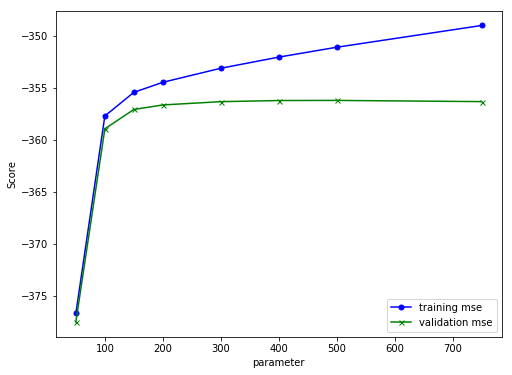

In [49]:
%%time
# Apply lightGBM regressor model to training data
lgbmRegressor = lgbm.LGBMRegressor(random_state = 3, max_depth = 7, learning_rate = 0.1, objective ='regression', n_jobs = -1)
curve_validation(lgbmRegressor, 'n_estimators',[50,100,150,200,300,400,500,750], X_train_final, y_train,'neg_mean_squared_error', 5)

### Examine feature fraction from validation curve
### Optimal value of feature fraction after which validation mse starts increasing is 0.8

Wall time: 4min 8s


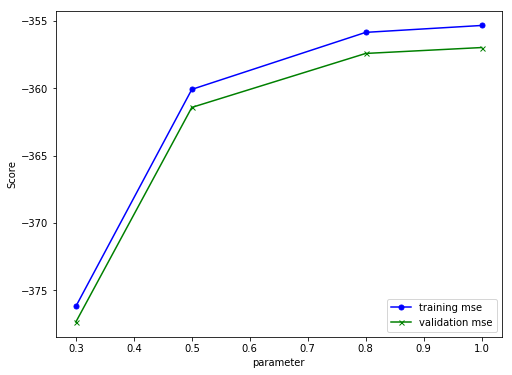

In [69]:
%%time
# Apply lightGBM regressor model to training data
lgbmRegressor = lgbm.LGBMRegressor(random_state = 3, max_depth = 7, learning_rate = 0.1, n_estimators = 150, n_jobs = -1, objective = 'regression')
curve_validation(lgbmRegressor, 'feature_fraction',[1, 0.8, 0.5, 0.3], X_train_final, y_train,'neg_mean_squared_error', 5)

### Examine num of leaves from validation curve
### Optimal value of the parameter after which validation mse becomes constant is 70

Wall time: 4min 40s


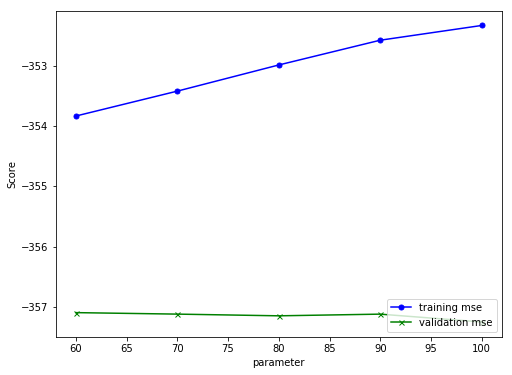

In [59]:
%%time
# Apply lightGBM regressor model to training data
lgbmRegressor = lgbm.LGBMRegressor(random_state = 3, max_depth = 7, learning_rate = 0.1, 
                                   n_estimators = 150, feature_fraction = 0.8, 
                                   objective = 'regression', n_jobs = -1)
curve_validation(lgbmRegressor, 'num_leaves',[60,70,80,90,100], X_train_final, y_train,'neg_mean_squared_error', 5)

### Perform GridSearchCV

In [71]:
from sklearn.model_selection import GridSearchCV

In [72]:
# Define Parameters

param_grid = {"max_depth": [7,8,9],
              "max_features" : [1.0,0.8,0.9],
              "num_leaves" : [70,80,90],
              "n_estimators": [100,150,200],
              "learning_rate": [0.1,0.15,0.2]}

In [53]:
# Perform Grid Search CV

lgbmRegressor = lgbm.LGBMRegressor(random_state = 3, objective = 'regression', n_jobs = -1)

gs_cv = GridSearchCV(lgbmRegressor, param_grid= param_grid, cv = 3, verbose=10, scoring = 'neg_mean_squared_error', n_jobs = -1).fit(X_train_final, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 24.7min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed: 35.1min
[Paralle

### ---- 9 Test models ----

In [54]:
# Best hyperparmeter setting
gs_cv.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=7,
       max_features=1.0, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=70,
       objective='regression', random_state=3, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [73]:
# Use our best model parameters found by GridSearchCV

LGBM_best_model = lgbm.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=7,
       max_features=1.0, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=70,
       objective='regression', random_state=3, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

### Fitting LGBM model with 5 fold cross validation

In [74]:
lgbm_mse = model_metric_scores(LGBM_best_model,X_train_final, y_train, 5)

The best MSE Score for given data: 356.4254612665808


### ---- 10 Select best model  ---- 
### Light GBM selected

In [75]:
### Storing results
### select the model with the lowest error as your "prodcuction" model

model_cv_scores = {'Baseline_Lr':lr_baseline_mse,
                'Linear_regression': lr_mse,
                'Ridge_regression': ridge_mse,
                'Lasso_regression': lasso_mse,
                'Random_Forest': rf_mse,
                'LightGBM': lgbm_mse}

model_cv_scores_df = pd.DataFrame.from_dict(model_cv_scores, orient = 'index', columns= ['MSE_score'])
model_cv_scores_df

,MSE_score
Baseline_Lr,384.409639
Linear_regression,384.414141
Ridge_regression,384.414255
Lasso_regression,384.418663
Random_Forest,369.383039
LightGBM,356.425461


### Plotting results on bar chart

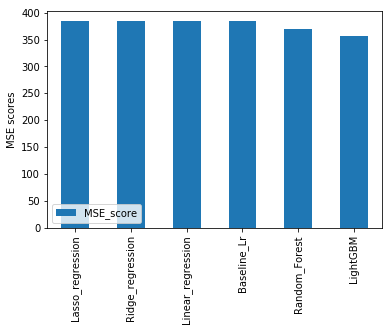

In [80]:
model_cv_scores_df.sort_values(by = 'MSE_score', ascending = False).plot(kind ='bar')
plt.ylabel('MSE scores')
plt.legend(loc = 'lower left')
plt.show()

In [88]:
best_model = LGBM_best_model

### Prepare test dataset

In [91]:
test_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


### Examine missing values in test data

In [92]:
test_features.isnull().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64

In [93]:
### Create a copy of test data

test_features_copy = test_features.copy()

### Feature engineering and data preparation columns in test data

In [94]:
## create new features from experience and miles

test_features_copy = preprocess_experience(test_features_copy)
test_features_copy = preprocess_miles(test_features_copy)

## Drop job ID and company ID column from the dataframe

test_features_copy = drop_columns(test_features_copy,['jobId','companyId'])

### Creating dummy variables in test set and data preparation

In [95]:
### Create list of numerical and categorical features using predefined function

num_var_test, cat_var_test = features_set(test_features_copy)

### Creating dummy features for categorical features in the X_train dataframe

test_df_final = feature_encoding(test_features_copy, cat_var_test)
test_df_final.shape

(1000000, 34)

### Predictions on test data

In [96]:
best_model.fit(X_train_final, y_train)

### Predictions on test data

predictions = best_model.predict(test_df_final)

test_features['predictions'] = predictions

### extracting the jobid and predictions columns from the dataframe

test_salaries = test_features[['jobId','predictions']]

### ---- 11 Deploy solution ----

In [ ]:
### Storing prediction results as a csv file

test_salaries.to_csv('test_salaries.csv', index = False)

### Store important features as a csv file

feature_importances.to_csv('feature_importances.csv')